# An Introduction to Spatio-Temporal Forecasting Using Graph Neural Netoworks

Not as hands-on as the previous lessons. Especially at the begining!


## Part 1:
- What is spatio-temporal forecasting?
- Node similarities and adjacency matrix
- Exploring one spatio-temporal dataset



## Part 2: 
- Training a graph neural network for spatio-temporal forecasting

</br></br></br></br>

### What is spatio-temporal forecasting?

A forecasting task in which the dataset has not only temporal features (time, seasonality, trend) but also spatial features (location, distance)

#### Example: 
- Traffic foreacsting

<div style="text-align: center;">
  <img src="Figures/METR-LA.png" alt="Sensor distribution of the METR-LA" width="600"/>
  <div style="font-size: 14px; margin-top: 8px;"><em>Figure 1:</em> Sensor locations in the METR-LA dataset [arXiv:1707.01926]</div>
</p>



<div style="text-align: center;">
  <img src="Figures/Speed2.png" alt=". width="1200"/>
  <div style="font-size: 14px; margin-top: 8px;"><em>Figure 2:</em> Average Traffic Speed (mph)</div>
</p>

#### Example: 
- Traffic foreacsting

    - Two types of dependency:

        - Temporal dependency within one series (intra-series correlation)

            - Measurement of one sensor at time t depends on its previous measurements ... just like any other times series

        - Spatial dependency between two series (Inter-series spatial correlation)

<br><br><br>
#### Why is there a need to handle this problem as a special forecasting case?

- Data is typically limited.

- Models are not perfect.

- Improve forecasting performance by incorporating spatial information explicitly. 


<br><br><br>

#### OK! Why not simply add distance as a new feature?

- Distance alone may not capture the dependencies fully.
        
    Example:
    - Measurements of two traffic sensors that are physically close to each other (A&C) but measure traffic flowing in opposite directions of a road (one monitoring eastbound lanes and the other monitoring westbound lanes), may not show strong correlation.

</br>
<div style="text-align: center;">
  <img src="Figures/StreetSensors.png" alt="" width="900"/>
  <div style="font-size: 14px; margin-top: 8px;"><em></em></div>
</div>

</br>

- It is the underlying topology of a geometrical system, not just the distances between nodes, that determines inter-series dependencies.

<br><br><br>

### A Framework to Incorporate Spatial Information in Model Training
- Key Definitions
  - Adjacency Matrix
  - Weighted Adjacency Matrix


#### Adjacency Matrix
- A matrix that shows whether a given pair of nodes are connected or not.  
  - What are nodes? What does being connected mean?

- A simple example with 4 traffic sensors
  
  - Each sensor is one node.

  - Connection definition is more tricky.

    - Example: 
  
      - Two nodes (sensors) are connected if there is a driving path between them that does not pass through any other sensor.
    
      - Connection direction = driving direction
  
  - Graph representation and adjacency matrix

  - These are just examples.

    - Connection in the opposite direction may also make sense (depending on the application)

</br>
<div style="text-align: center;">
  <img src="Figures/StreetSensors.png" alt="" width="900"/>
  <div style="font-size: 14px; margin-top: 8px;"><em></em></div>
</div>

</br>



</br>
<div style="text-align: center;">
  <img src="Figures/StreeSensorsGraphAndAdjacency.png" alt="" width="900"/>
  <div style="font-size: 14px; margin-top: 8px;"><em></em></div>
</div>

</br>





- Why make it so difficult? Compare two scnearios:
    - A) Showing to an ML model the presence of such complex connections using such a matrix. 

    vs.

    - B) Giving to the model only nodal locations and leaving it up to the model to learn those connections from the data.

    Scenario B is better feature engineering! </br></br></br>



- What if we want to show not just if a connection exists or not but also how strong it is?
    
    - Connection between C and D is stronger than between A and B.


<br><br><br>

#### Weighted Adjacency Matrix

- It shows not only if two nodes are connected or not but also how strong the connection between them is. 

- We need a notion of connection strength.
    
    - Ex. distance between nodes: the lower the distance the stronger the connection.

    - What type of distance?

        - Depends on the application.

            - In traffic monitoring example: road-network distance.

</br></br></br></br></br></br></br></br>






- Thresholded Gaussian kernel
    - Imagine nodes $i$ and $j$. Element $i$, $j$ of the matrix, representing the weight of the edge connecting them, $w_t^{i,j}$, is <br>
$$
\Huge
w^{i,j} = \left\{
\begin{array}{cl}
     \exp \left(-\frac{\textcolor{red}{\operatorname{dist}\left(i, j\right)}^{2}}{\textcolor{green}{\sigma}^{2}}\right) & \textcolor{red}{\operatorname{dist}\left(i, j\right)} \leq \textcolor{blue}{\delta}  \\
     0 & \text{otherwise}
\end{array}
\right. ,
$$


<div style="padding-left: 70px">

$\operatorname{dist}\left(i, j\right)$ is a notion of distance between $i$-th and $j$-th node. Depends on application. 

$\delta$ is a threshold.

If the distance between the $i$-th and $j$-th nodes is greater than $\delta$, they are not connected

$\sigma$ standard deivation of distances.

</div>

</br></br></br></br></br></br>

### Exploring Spatio-Temporal Datasets using TorchSpatioTemporal (TSL) Library

In [1]:
# Install required packages.
import os
import torch
import numpy as np
import tsl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
os.environ['TORCH'] = torch.__version__
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(edgeitems=3, precision=3)
torch.set_printoptions(edgeitems=2, precision=3)

print(f"tsl version  : {tsl.__version__}")
print(f"torch version: {torch.__version__}")


tsl version  : 0.9.5
torch version: 2.6.0+cpu


In [2]:
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q git+https://github.com/TorchSpatiotemporal/tsl.git

In [3]:
# Utility functions ################
def print_matrix(matrix):
    return pd.DataFrame(matrix)

def print_model_size(model):
    tot = sum([p.numel() for p in model.parameters() if p.requires_grad])
    out = f"Number of model ({model.__class__.__name__}) parameters:{tot:10d}"
    print("=" * len(out))
    print(out)

#### [MetrLA](https://paperswithcode.com/sota/traffic-prediction-on-metr-la) Dataset 

<div style="text-align: center;">
  <img src="Figures/METR-LA.png" alt="Sensor distribution of the METR-LA" width="600"/>
  <div style="font-size: 14px; margin-top: 8px;"><em>Figure 1:</em> Sensor locations in the METR-LA dataset [arXiv:1707.01926]</div>
</p>




- Dataset of traffic information collected sensors in of Los Angeles County highways (Jagadish et al., 2014).
- Number of sensors: 207 sensors (road segments)
- Features:
    - Each sensor records average traffic speed at a given timestamp.
- Frequency: 5-minute intervals
- Time span: Mar 1st 2012 to Jun 30th 2012 (4 months)



In [4]:
from tsl.datasets import MetrLA

dataset = MetrLA(root='/home/mahdi/MLBoost/ForecastingCourse/GNNs/data/MetrLA')

/home/mahdi/Downloads/yes/envs/tsl/lib/python3.12/site-packages/tsl/datasets/metr_la.py:98: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  date_range = pd.date_range(df.index[0], df.index[-1], freq='5T')
/home/mahdi/Downloads/yes/envs/tsl/lib/python3.12/site-packages/tsl/datasets/metr_la.py:109: FutureWarning: The 'method' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  df = df.replace(to_replace=0., method='ffill')


##### MetrLA Dataset High-Level Overview

In [5]:
# Display dataset info
dataset_name = f"dataset: {dataset}"
sample_period = f"Sampling period: {dataset.freq}"
missing_values_status = f"Has missing values: {dataset.has_mask}"
missing_percentage = f"Percentage of missing values: {(1 - dataset.mask.mean()) * 100:.2f}%"
covariates_status = f"Has Covariates: {dataset.has_covariates}"
covariate_list = f"Covariates: {', '.join(dataset.covariates.keys())}"

# Output information
print(dataset_name)
print(sample_period)
print(missing_values_status)
print(missing_percentage)
print(covariates_status)
print(covariate_list)

dataset: MetrLA(length=34272, n_nodes=207, n_channels=1)
Sampling period: <5 * Minutes>
Has missing values: True
Percentage of missing values: 8.11%
Has Covariates: True
Covariates: dist


##### Pandas Represenation of Dataset

In [6]:
df = dataset.dataframe() # multi-index df. Upper index ... nodes, lower index ... channels.
df

nodes,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
channels,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-03-01 00:00:00,64.38,67.62,67.12,61.50,66.88,68.75,65.12,67.12,59.62,62.75,...,45.62,65.50,64.50,66.43,66.88,59.38,69.00,59.25,69.00,61.88
2012-03-01 00:05:00,62.67,68.56,65.44,62.44,64.44,68.11,65.00,65.00,57.44,63.33,...,50.67,69.88,66.67,58.56,62.00,61.11,64.44,55.89,68.44,62.88
2012-03-01 00:10:00,64.00,63.75,60.00,59.00,66.50,66.25,64.50,64.25,63.88,65.38,...,44.12,69.00,56.50,59.25,68.12,62.50,65.62,61.38,69.86,62.00
2012-03-01 00:15:00,64.00,63.75,60.00,59.00,66.50,66.25,64.50,64.25,63.88,65.38,...,44.12,69.00,56.50,59.25,68.12,62.50,65.62,61.38,69.86,62.00
2012-03-01 00:20:00,64.00,63.75,60.00,59.00,66.50,66.25,64.50,64.25,63.88,65.38,...,44.12,69.00,56.50,59.25,68.12,62.50,65.62,61.38,69.86,62.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-06-27 23:35:00,65.00,65.89,68.56,61.67,32.83,54.56,62.44,63.33,59.22,65.33,...,52.89,69.00,65.11,55.67,66.33,62.44,66.78,64.89,69.67,62.33
2012-06-27 23:40:00,61.38,65.62,66.50,62.75,32.83,50.50,62.00,67.00,65.25,67.12,...,54.00,69.25,60.12,60.50,67.25,59.38,66.00,61.25,69.00,62.00
2012-06-27 23:45:00,67.00,59.67,69.56,61.00,32.83,44.78,64.22,63.78,59.78,57.67,...,51.33,67.89,64.33,57.00,66.00,62.67,68.67,63.33,67.44,61.22


##### Dataset Nodal Values: Average Speed in mph

Text(0, 0.5, 'Average Traffic Speed (mph)')

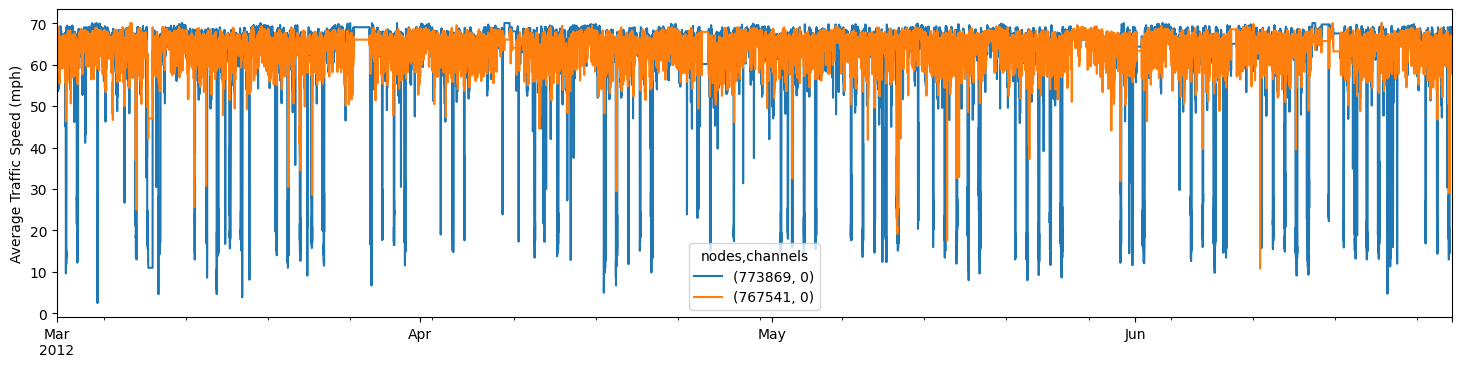

In [7]:
ax = df[[('773869', 0), ('767541', 0)]].plot(figsize=(18, 4))
ax.set_ylabel('Average Traffic Speed (mph)')

In [8]:
'''
ax = df[['773869', '767541']].head(12*24).plot(figsize=(16, 4))
ax.set_ylabel('Average Traffic Speed (mph)')
plt.tight_layout()
plt.savefig('Speed.png')
'''

"\nax = df[['773869', '767541']].head(12*24).plot(figsize=(16, 4))\nax.set_ylabel('Average Traffic Speed (mph)')\nplt.tight_layout()\nplt.savefig('Speed.png')\n"

### Distance Matrix




In [9]:
print_matrix(dataset.dist)

,0,1,2,3,4,5,6,7,8,9,...,197,198,199,200,201,202,203,204,205,206
0,0.00,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,3764.70,inf,inf,9204.30,inf,inf,8114.80,10009.70
1,inf,0.00,2504.60,8563.80,8572.50,9561.00,9590.00,2506.30,inf,inf,...,inf,inf,inf,inf,4941.90,7559.20,7877.20,inf,inf,inf
2,inf,1489.30,0.00,6971.30,6978.30,9148.20,9177.10,3995.70,inf,inf,...,inf,9467.80,inf,inf,6431.40,7821.80,9366.60,inf,inf,9837.00
3,inf,6805.90,9293.60,0.00,1745.50,6068.80,5401.50,9312.30,inf,inf,...,inf,5906.50,inf,inf,inf,inf,inf,inf,inf,7604.40
4,inf,6606.70,9111.30,1767.40,0.00,4464.00,3655.90,9113.10,inf,inf,...,inf,7207.10,inf,inf,inf,inf,inf,inf,inf,8905.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,inf,inf,10987.10,inf,inf,inf,inf,10133.60,inf,inf,...,inf,inf,inf,inf,9098.90,0.00,4072.70,inf,inf,inf
203,inf,10723.20,9461.80,inf,inf,inf,inf,8608.30,inf,inf,...,inf,inf,inf,inf,7283.50,inf,0.00,inf,inf,inf
204,inf,inf,inf,inf,inf,inf,inf,inf,9189.80,3171.10,...,3672.40,inf,inf,inf,inf,inf,inf,0.00,inf,inf
205,9599.80,inf,inf,inf,inf,inf,inf,inf,inf,10167.50,...,inf,inf,10500.80,inf,inf,inf,inf,inf,0.00,inf


#### Euclidean vs. Road-Network Distances

In [10]:
from tsl.ops.similarities import geographical_distance 
# measures the shortest distance on the Earth’s surface without factoring in roads, rivers, or other obstacles

In [11]:
#34.15497,-118.31829
#34.11621,-118.23799
node_0_lat_long = [34.15497,-118.31829] # 
node_1_lat_long = [34.11621,-118.23799]
node_2_lat_long = [34.11641,-118.23819]

x = np.array([node_0_lat_long, node_1_lat_long, node_2_lat_long])
geographical_distance_matrix = 1000*geographical_distance(x)
geographical_distance_matrix

array([[   0.   , 8555.498, 8528.392],
       [8555.498,    0.   ,   28.872],
       [8528.392,   28.872,    0.   ]])

Differences betweeen geographical_distance and dataset.dist
- geographical_distance is symmetric.
- Consider nodes 1 and 2. Their geographical distance is only 22 meters. But their road network distance was more than 2km.

#### From Raw Distances to Node-Similarity (Edge-Weight) Matrix

$$
w^{i,j} = \left\{
\begin{array}{cl}
     \exp \left(-\frac{\textcolor{red}{\operatorname{dist}\left(i, j\right)}^{2}}{\textcolor{green}{\sigma}^{2}}\right) & \textcolor{red}{\operatorname{dist}\left(i, j\right)} \leq \textcolor{blue}{\delta}  \\
     0 & \text{otherwise}
\end{array}
\right. ,
$$


- get_connectivity()
- get_similarity()


In [12]:
w_i_j_sim = dataset.get_similarity()

print("Similarity matrix:")
print_matrix(w_i_j_sim)

Similarity matrix:


,0,1,2,3,4,5,6,7,8,9,...,197,198,199,200,201,202,203,204,205,206
0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,1.00,0.39,0.00,0.00,0.00,0.00,0.39,0.00,0.00,...,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00
2,0.00,0.72,1.00,0.00,0.00,0.00,0.00,0.09,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,1.00,0.63,0.00,0.01,0.00,0.00,0.00,...,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.63,1.00,0.05,0.14,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.08,0.00,0.00,0.00
203,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
204,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.22,...,0.13,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
205,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


##### Check Gaussian Kernel Implementation Provided by get_similarity()


In [13]:
print('distance between nodes 1 and 2 ',  dataset.dist[1, 2])
finite_dis = dataset.dist[~np.isinf(dataset.dist)]
std = np.std(finite_dis)
print('standard deviation of finite distances: ', std)
print('directly calculated similarity: ',  np.exp(-np.square(dataset.dist[1, 2] / std)))
print('similarity from get_similairty(): ', w_i_j_sim[1, 2])

distance between nodes 1 and 2  2504.6
standard deviation of finite distances:  2584.4502
directly calculated similarity:  0.3909554
similarity from get_similairty():  0.3909554


##### get_connectivity() can reproduce get_similarity() outputs and more.

In [14]:
w_i_j_connectivity_dense = dataset.get_connectivity(layout="dense") # returns weighted adjacency matrix similar to sim
np.testing.assert_array_equal(w_i_j_connectivity_dense, w_i_j_sim)


### Adjacency matrix can become very large very quickly.
- Most of its values are zero, or very small!
- How to get a more efficient representation of it?

In [15]:
print_matrix(w_i_j_connectivity_dense)

,0,1,2,3,4,5,6,7,8,9,...,197,198,199,200,201,202,203,204,205,206
0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,1.00,0.39,0.00,0.00,0.00,0.00,0.39,0.00,0.00,...,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00
2,0.00,0.72,1.00,0.00,0.00,0.00,0.00,0.09,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,1.00,0.63,0.00,0.01,0.00,0.00,0.00,...,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.63,1.00,0.05,0.14,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.08,0.00,0.00,0.00
203,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
204,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.22,...,0.13,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
205,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


##### Zero vs. Non-Zero Values

In [16]:
print('ratio (pct.) = ', 100*w_i_j_connectivity_dense[w_i_j_connectivity_dense > 0].size/w_i_j_connectivity_dense.size)

ratio (pct.) =  27.428878153515836


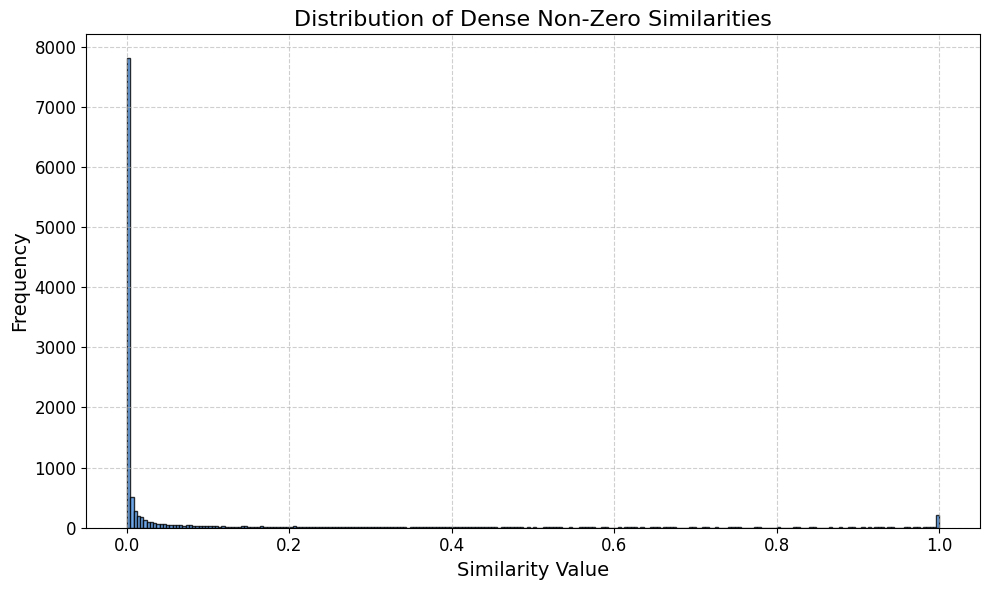

In [17]:
plt.figure(figsize=(10, 6))  # Bigger figure for readability

# Plot histogram
plt.hist(w_i_j_connectivity_dense[w_i_j_connectivity_dense > 0].flatten(), bins=250, edgecolor='black', color='#4a90e2', alpha=0.8)

# Title and labels
plt.title('Distribution of Dense Non-Zero Similarities', fontsize=16)
plt.xlabel('Similarity Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Grid and ticks
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Optional: tight layout
plt.tight_layout()

plt.show()


##### Remove nearly-zero similarity values.

In [18]:
w_i_j_connectivity_dense_with_threshold = dataset.get_connectivity(layout="dense", threshold=0.01) 
print_matrix(w_i_j_connectivity_dense_with_threshold)

,0,1,2,3,4,5,6,7,8,9,...,197,198,199,200,201,202,203,204,205,206
0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,1.00,0.39,0.00,0.00,0.00,0.00,0.39,0.00,0.00,...,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00
2,0.00,0.72,1.00,0.00,0.00,0.00,0.00,0.09,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,1.00,0.63,0.00,0.01,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.63,1.00,0.05,0.14,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.08,0.00,0.00,0.00
203,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
204,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.22,...,0.13,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
205,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


In [19]:
print('ratio (pct.)=',100* w_i_j_connectivity_dense_with_threshold[w_i_j_connectivity_dense_with_threshold>0].size/w_i_j_connectivity_dense_with_threshold.size)

ratio (pct.)= 7.673457957011832


##### Remove self-connections.

In [20]:
w_i_j_connectivity_dense_with_threshold_no_self = dataset.get_connectivity(layout="dense", threshold=0.01, include_self=False) 
print_matrix(w_i_j_connectivity_dense_with_threshold_no_self)

,0,1,2,3,4,5,6,7,8,9,...,197,198,199,200,201,202,203,204,205,206
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.39,0.00,0.00,0.00,0.00,0.39,0.00,0.00,...,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00
2,0.00,0.72,0.00,0.00,0.00,0.00,0.00,0.09,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.63,0.00,0.01,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.63,0.00,0.05,0.14,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.00,0.00,0.00
203,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
204,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.22,...,0.13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
205,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [21]:
print('ratio (pct.)=', 100*w_i_j_connectivity_dense_with_threshold_no_self[w_i_j_connectivity_dense_with_threshold_no_self>0].size/w_i_j_connectivity_dense.size)

ratio (pct.)= 7.1903661695722185


##### Shouldn't we normalize weights?

In [22]:
print(w_i_j_connectivity_dense_with_threshold_no_self[0, :].sum())
print(w_i_j_connectivity_dense_with_threshold_no_self[1, :].sum())
print(w_i_j_connectivity_dense_with_threshold_no_self[2, :].sum())


4.088782
3.2296014
4.083776


In [23]:
w_i_j_connectivity_dense_with_threshold_no_self_normalized = dataset.get_connectivity(
    layout="dense",
    threshold=0.01,
    include_self=False,
    normalize_axis=1 # Weights of edges outgoing from a node sum to one.
    ) 
print(w_i_j_connectivity_dense_with_threshold_no_self_normalized[0, :].sum())
print(w_i_j_connectivity_dense_with_threshold_no_self_normalized[1, :].sum())
print(w_i_j_connectivity_dense_with_threshold_no_self_normalized[2, :].sum())


1.0
1.0
1.0


In [24]:
## So many things going on with connection matrix.
## TODO: I need figures here.
w_i_j_connectivity_dense = dataset.get_connectivity(
    layout="dense",
    threshold=0.01,
    include_self=False,
    normalize_axis=1
    )

w_i_j_connectivity_edge_index = dataset.get_connectivity(
    layout="edge_index",
    threshold=0.01,
    include_self=False,
    normalize_axis=1
    )

edges, edge_weights = w_i_j_connectivity_edge_index

In [25]:
edges

array([[  0,   0,   0, ..., 206, 206, 206],
       [ 13,  36,  58, ..., 188, 195, 198]])

In [26]:
edge_weights

array([0.072, 0.151, 0.029, ..., 0.008, 0.003, 0.109], dtype=float32)

#### Check consistency of sparce and dense formats

In [27]:
edge_index = 0
print('edge weight from sparce rep. = ', w_i_j_connectivity_edge_index[1][edge_index])

print('edge nodes: ', w_i_j_connectivity_edge_index[0][:, edge_index])

indicies = list((w_i_j_connectivity_edge_index[0][:, edge_index]))
print('edge weight from dense rep. = ', w_i_j_connectivity_dense[indicies[1], indicies[0]])

edge weight from sparce rep. =  0.072395526
edge nodes:  [ 0 13]
edge weight from dense rep. =  0.072395526


In [28]:
from tsl.ops.connectivity import edge_index_to_adj
adj = edge_index_to_adj(edges, edge_weights)
adj

array([[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.121, ..., 0.   , 0.   , 0.   ],
       [0.   , 0.176, 0.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]], dtype=float32)

In [29]:
w_i_j_connectivity_dense

array([[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.121, ..., 0.   , 0.   , 0.   ],
       [0.   , 0.176, 0.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]], dtype=float32)

In [30]:
np.testing.assert_array_equal(w_i_j_connectivity_dense, adj)


### Building a PyTorch-ready dataset
<hr>


In [31]:
from tsl.data import SpatioTemporalDataset
horizon, window, stride = 12, 12, 1
torch_dataset = SpatioTemporalDataset(
    target=dataset.dataframe(),
    connectivity=w_i_j_connectivity_edge_index,
    mask=dataset.mask,
    horizon=horizon,
    window=window,
    stride=stride,
    delay=0
    )
print(torch_dataset)
# How many time steps are covered by one sample?

SpatioTemporalDataset(n_samples=34249, n_nodes=207, n_channels=1)


In [32]:
torch_dataset

SpatioTemporalDataset(n_samples=34249, n_nodes=207, n_channels=1)

In [33]:
a_sample = torch_dataset[0]
print(a_sample)

Data(
  input=(x=[t=12, n=207, f=1], edge_index=[2, e=3081], edge_weight=[e=3081]),
  target=(y=[t=12, n=207, f=1]),
  has_mask=True
)


In [34]:
num_false = (~a_sample.mask).sum().item()
print(num_false)


24


##### Investigate Input

In [35]:
input_dic = a_sample.input.to_dict()
print(input_dic.keys())
print(input_dic['x'].shape), print(input_dic['x'][:, 0, 0])
print(input_dic['edge_index'])
print(input_dic['edge_weight'])

dict_keys(['x', 'edge_index', 'edge_weight'])
torch.Size([12, 207, 1])
tensor([64.375, 62.667, 64.000, 64.000, 64.000, 57.333, 66.500, 63.625, 68.750,
        63.500, 65.222, 62.250])
tensor([[  0,   0,  ..., 206, 206],
        [ 13,  36,  ..., 195, 198]])
tensor([0.072, 0.151,  ..., 0.003, 0.109])


##### Investigate Target

In [36]:
target_dic = a_sample.target.to_dict()
print(target_dic.keys())
print(target_dic['y'].shape)
print(target_dic['y'][:, 0, 0])

dict_keys(['y'])
torch.Size([12, 207, 1])
tensor([61.125, 58.556, 63.625, 66.778, 55.875, 64.333, 63.889, 63.125, 62.125,
        61.500, 63.222, 65.000])


In [37]:
## Pattern makes things easy
a_sample.pattern

{'x': 't n f',
 'mask': 't n f',
 'edge_index': '2 e',
 'edge_weight': 'e',
 'y': 't n f'}

In [38]:
a_sample.input.x.shape

torch.Size([12, 207, 1])

In [39]:
a_sample

Data(
  input=(x=[t=12, n=207, f=1], edge_index=[2, e=3081], edge_weight=[e=3081]),
  target=(y=[t=12, n=207, f=1]),
  has_mask=True
)

In [40]:
a_sample.input.x

tensor([[[64.375],
         [67.625],
         ...,
         [69.000],
         [61.875]],

        [[62.667],
         [68.556],
         ...,
         [68.444],
         [62.875]],

        ...,

        [[65.222],
         [63.667],
         ...,
         [67.222],
         [60.000]],

        [[62.250],
         [67.750],
         ...,
         [66.500],
         [59.429]]])

### Batching spatiotemporal graph signals


In [41]:
#batch = torch_dataset[:5]
#print(batch)

### Preparing the dataset for training
<hr>


In [42]:
from tsl.data.datamodule import (SpatioTemporalDataModule,
                                 TemporalSplitter)
from tsl.data.preprocessing import StandardScaler

# Normalize data using mean and std computed over time and node dimensions
scalers = {'target': StandardScaler(axis=(0, 1))}

# Split data sequentially:
#   |------------ dataset -----------|
#   |--- train ---|- val -|-- test --|
splitter = TemporalSplitter(val_len=0.1, test_len=0.2)

# We need something that can be passed to fit of pytorch lightening trainer
# Torch dataset + any transformation + a splitter + batching
data_module_instance = SpatioTemporalDataModule(
    dataset=torch_dataset,
    scalers=scalers,
    splitter=splitter,
    batch_size=64,
)
data_module_instance

SpatioTemporalDataModule(train_len=None, val_len=None, test_len=None, scalers=[target], batch_size=64)


<div style="text-align: center;">
  <img src="Figures/Splitting.png" alt="[https://torch-spatiotemporal.readthedocs.io/en/latest/notebooks/a_gentle_introduction_to_tsl.html]" width="600"/>
  <div style="font-size: 14px; margin-top: 8px;"><em> https://torch-spatiotemporal.readthedocs.io/en/latest/notebooks/a_gentle_introduction_to_tsl.html </div>
</p>



In [43]:
data_module_instance.setup()
print(data_module_instance)

{Train dataloader: size=24648}
{Validation dataloader: size=2728}
{Test dataloader: size=6849}
{Predict dataloader: None}


In [44]:
import torch.nn as nn

from tsl.nn.blocks.encoders import RNN
from tsl.nn.layers import NodeEmbedding, DiffConv
from einops.layers.torch import Rearrange  # reshape data with Einstein notation

### Designing a custom Spatio-Temporal GNN
<hr>


How should our neural network architecture look like?

Obvious components:
    
- RNN to learn temporal dependencies
    
- Encode, thus decoder
    - Handle mismatch between input/output sizes.
    - ...
    
- Spatial processing 

Less obvious one:

- ?
- Cini, A., Marisca, I., Zambon, D., & Alippi, C. (2023). Taming local effects in graph-based spatiotemporal forecasting. Advances in Neural Information Processing Systems, 36, 55375-55393.
- Is there really no other way than adding a node embedding layer?
- More research?
</br></br></br></br>

</br></br>
Li, Y., Yu, R., Shahabi, C., & Liu, Y. (2017). Diffusion convolutional recurrent neural network: Data-driven traffic forecasting. arXiv preprint arXiv:1707.01926.
- Random Walk
  - Probability of ending up in B when starting point is A

<div style="text-align: center;">
  <img src="Figures/RandomWalk.png" alt="[]" width="900"/>
  <div style="font-size: 14px; margin-top: 8px;"><em>  </div>
</p>
</br></br>



  - if we make a random walk assumption, probability of transitionins from any given node to any other node can be calculated.

  
  - P is a matrix that shows prob. of ending up in node j when starting node is i.

<div style="text-align: center;">
  <img src="Figures/SpatialDep1.png" alt="[]" width="900"/>
  <div style="font-size: 14px; margin-top: 8px;"><em>  </div>
</p>
</br></br>

- How to incorporate Eq. (1) in our neural netwokr?

<div style="text-align: center;">
  <img src="Figures/SpatialDep2.png" alt="[]" width="900"/>
  <div style="font-size: 14px; margin-top: 8px;"><em>  </div>
</p>
</br></br>

In [45]:
class TimeThenSpaceModel(nn.Module):
    def __init__(
            self,
            input_size: int,        # num features
            n_nodes: int,           # num nodes
            horizon: int,           # forecast horizon
            hidden_size: int = 32,
            rnn_layers: int = 1,
            gnn_kernel: int = 2
            ):

        super(TimeThenSpaceModel, self).__init__()

        self.encoder = nn.Linear(input_size, hidden_size)           # linear encoder: x_enc = xΘ + b ... output of size 

        self.node_embeddings = NodeEmbedding(n_nodes, hidden_size)  # 

        # Time
        self.time_nn = RNN(
            input_size=hidden_size,
            hidden_size=hidden_size,
            n_layers=rnn_layers,
            cell='gru',
            return_only_last_state=True
            )

        # Space
        self.space_nn = DiffConv(
            in_channels=hidden_size,
            out_channels=hidden_size,
            k=gnn_kernel
            )

        self.decoder = nn.Linear(hidden_size, input_size * horizon)
        self.rearrange = Rearrange('b n (t f) -> b t n f', t=horizon)

    def forward(self, x, edge_index, edge_weight):
        # x: [batch time nodes features]
        x_enc = self.encoder(x)                         # linear encoder: x_enc = xΘ + b
        x_emb = x_enc + self.node_embeddings()          # add node-identifier embeddings    # Eq. (15) in the paper.
        h = self.time_nn(x_emb)                         # temporal processing: x=[b t n f] -> h=[b n f]
        z = self.space_nn(h, edge_index, edge_weight)   # spatial processing
        x_out = self.decoder(z)                         # linear decoder: z=[b n f] -> x_out=[b n t⋅f]
        x_horizon = self.rearrange(x_out)
        return x_horizon

In [46]:
torch_dataset.n_channels

1

In [ ]:
# Set parameters for RNN component
hidden_size = 32   # @param
rnn_layers = 1     # @param
gnn_kernel = 2     # We will get to what this is?

input_size = torch_dataset.n_channels   # 1 channel
n_nodes = torch_dataset.n_nodes         # 207 nodes
horizon = torch_dataset.horizon         # 12 time steps

stgnn = TimeThenSpaceModel(
    input_size=input_size, # num features
    n_nodes=n_nodes,
    horizon=horizon,
    hidden_size=hidden_size,
    rnn_layers=rnn_layers,
    gnn_kernel=gnn_kernel
    )

print(stgnn)
print_model_size(stgnn)

TimeThenSpaceModel(
  (encoder): Linear(in_features=1, out_features=32, bias=True)
  (node_embeddings): NodeEmbedding(n_nodes=207, embedding_size=32)
  (time_nn): RNN(
    (rnn): GRU(32, 32)
  )
  (space_nn): DiffConv(32, 32)
  (decoder): Linear(in_features=32, out_features=12, bias=True)
  (rearrange): Rearrange('b n (t f) -> b t n f', t=12)
)
Number of model (TimeThenSpaceModel) parameters:     18572


### Flow of one-sample across the neural network

In [68]:
# Follow one instance as it flows through the neural network
x = a_sample.input.x
x = x.unsqueeze(0) # add batch info
print('input (pre-encdoing) ', x.shape)

print('post encodig         ', stgnn.encoder(x).shape) # What does encoder do? Nothing but a linear layer!
print('node embedding       ', stgnn.node_embeddings().shape)
x_emb = stgnn.encoder(x) + stgnn.node_embeddings() 
print('input embedded       ', x_emb.shape)

h = stgnn.time_nn(x_emb[:, :, :, :])
print('post RNN             ', h.shape)

z = stgnn.space_nn(h, a_sample.input.edge_index, a_sample.input.edge_weight)
print('post GNN             ', z.shape)

x_out = stgnn.decoder(z)
print('post decoder         ', x_out.shape)

x_horizon = stgnn.rearrange(x_out)
print('re-arrangment        ', x_horizon.shape)

input (pre-encdoing)  torch.Size([1, 12, 207, 1])
post encodig          torch.Size([1, 12, 207, 32])
node embedding        torch.Size([207, 32])
input embedded        torch.Size([1, 12, 207, 32])
post RNN              torch.Size([1, 207, 32])
post GNN              torch.Size([1, 207, 32])
post decoder          torch.Size([1, 207, 12])
re-arrangment         torch.Size([1, 12, 207, 1])


In [ ]:
from tsl.metrics.torch import MaskedMAE, MaskedMAPE
from tsl.engines import Predictor

loss_fn = MaskedMAE()

metrics = {
    'mae': MaskedMAE(),
    'mape': MaskedMAPE(),
    'mae_at_15': MaskedMAE(at=2),  # '2' indicates the third time step, # which correspond to 15 minutes ahead (time stamp is every 5 mins)
    'mae_at_30': MaskedMAE(at=5),
    'mae_at_60': MaskedMAE(at=11),
    'mae_at_tmp': MaskedMAE(at=13)  # what will happen here?
    }

# setup predictor
predictor = Predictor(
    model=stgnn,                   # our initialized model
    optim_class=torch.optim.Adam,  # specify optimizer to be used...
    optim_kwargs={'lr': 0.001},    # ...and parameters for its initialization
    loss_fn=loss_fn,               # which loss function to be used
    metrics=metrics                # metrics to be logged during train/val/test
)

In [ ]:
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint


logger = TensorBoardLogger(save_dir="logs", name="tsl_intro", version=0)

checkpoint_callback = ModelCheckpoint(
    dirpath='logs',
    save_top_k=1, # number of best models to save.
    monitor='val_mae',
    mode='min',
)

In [ ]:
trainer = pl.Trainer(
    max_epochs=2, ## too low
    logger=logger,
    limit_train_batches=100,  # end an epoch after 100 updates
    callbacks=[checkpoint_callback]
    )

trainer.fit(predictor, datamodule=data_module_instance)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mahdi/Downloads/yes/envs/tsl/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/mahdi/MLBoost/ForecastingCourse/GNNs/logs exists and is not empty.

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | loss_fn       | MaskedMAE          | 0      | train
1 | train_metrics | MetricCollection   | 0      | train
2 | val_metrics   | MetricCollection   | 0      | train
3 | test_metrics  | MetricCollection   | 0      | train
4 | model         | TimeThenSpaceModel | 18.6 K | train
-------------------------------------------------------------
18.6 K    Trainable params
0         Non-trainable params
18.6 K    Total params
0.074     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/mahdi/Downloads/yes/envs/tsl/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
Only args ['x', 'edge_weight', 'edge_index'] are forwarded to the model (TimeThenSpaceModel).


/home/mahdi/Downloads/yes/envs/tsl/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 1: 100%|██████████| 100/100 [01:14<00:00,  1.34it/s, v_num=0, val_mae=3.170, val_mae_at_15=2.660, val_mae_at_30=3.140, val_mae_at_60=3.940, val_mae_at_tmp=0.000, val_mape=0.0866, train_mae=3.710, train_mae_at_15=3.050, train_mae_at_30=3.690, train_mae_at_60=4.690, train_mae_at_tmp=0.000, train_mape=0.104]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 100/100 [01:14<00:00,  1.34it/s, v_num=0, val_mae=3.170, val_mae_at_15=2.660, val_mae_at_30=3.140, val_mae_at_60=3.940, val_mae_at_tmp=0.000, val_mape=0.0866, train_mae=3.710, train_mae_at_15=3.050, train_mae_at_30=3.690, train_mae_at_60=4.690, train_mae_at_tmp=0.000, train_mape=0.104]


In [52]:
# MTR: https://github.com/suno-ai/bark/pull/619
# Save the original torch.load function
_original_torch_load = torch.load

# Define a new function that forces weights_only=False
def custom_torch_load(*args, **kwargs):
    if "weights_only" not in kwargs:
        kwargs["weights_only"] = False
    return _original_torch_load(*args, **kwargs)

# Override torch.load globally
torch.load = custom_torch_load

In [53]:
predictor.load_model(checkpoint_callback.best_model_path)
predictor.freeze()

trainer.test(predictor, datamodule=data_module_instance)

Predictor with already instantiated model is loading a state_dict from /home/mahdi/MLBoost/ForecastingCourse/GNNs/logs/epoch=1-step=200-v6.ckpt. Cannot  check if model hyperparameters are the same.
/home/mahdi/Downloads/yes/envs/tsl/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 108/108 [00:21<00:00,  5.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            3.703091859817505
        test_mae             3.85213565826416
     test_mae_at_15          3.152228832244873
     test_mae_at_30          3.818323850631714
     test_mae_at_60          4.911620616912842
     test_mae_at_tmp                0.0
        test_mape           0.10869994759559631
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_mae': 3.85213565826416,
  'test_mae_at_15': 3.152228832244873,
  'test_mae_at_30': 3.818323850631714,
  'test_mae_at_60': 4.911620616912842,
  'test_mae_at_tmp': 0.0,
  'test_mape': 0.10869994759559631,
  'test_loss': 3.703091859817505}]

In [54]:
data_module_instance.test_dataloader()

In [55]:
predict_loader = data_module_instance.test_dataloader()  # or define your own

predictions = trainer.predict(predictor, dataloaders=predict_loader)


/home/mahdi/Downloads/yes/envs/tsl/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 108/108 [00:16<00:00,  6.43it/s]


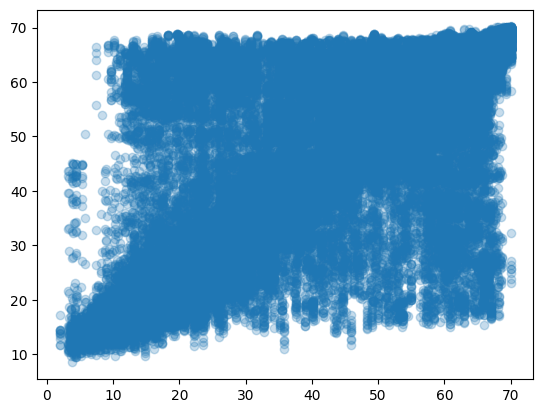

In [ ]:
#plt.scatter(predictions[0]['y'].flatten(), predictions[0]['y_hat'].flatten(), alpha=0.25)